# Data Cleaning
The census and arrests data needed cleaning and merging, as well as or selection process for nonviolent arrests and calculating the nearest Census Tract for each nonviolent arrest record. The complaints data did not require any cleaning and starts in the complaints EDA notebook 

---
## Imports
---

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import datetime
import time
import matplotlib.pyplot as plt

from tqdm import tqdm
from haversine import haversine, Unit
from sklearn.preprocessing import StandardScaler

sns.set(style="ticks", context="talk")
plt.style.use("fivethirtyeight")

In [2]:
block_tracts = pd.read_csv('./datasets/census_block_loc.csv')
tracts = pd.read_csv('./datasets/nyc_census_tracts.csv')
nypd = pd.read_csv('./datasets/NYPD_Arrests_Data__Historic_.csv')

---
## Data Cleaning
---

#### Census Tracts Blocking

In [3]:
# taking prefix numbers off BlockCodes
block_tracts['CensusTract'] = block_tracts['BlockCode'].map(lambda x: int(str(x)[0:11]))
block_tracts = block_tracts[block_tracts['State'] == 'NY']

In [4]:
# Copy to blocks and mean encode each Tract; drop duplicate columns 
blocks = block_tracts[['CensusTract', 'Latitude', 'Longitude']].copy()
# Lat
blocks['Latitude'] = blocks['CensusTract'].map(blocks.groupby('CensusTract')['Latitude'].mean())
# Long
blocks['Longitude'] = blocks['CensusTract'].map(blocks.groupby('CensusTract')['Longitude'].mean())
blocks.shape

(24240, 3)

In [5]:
blocks = blocks.drop_duplicates()
blocks = blocks.reset_index(drop=True)
# reduced by almost 13x while working just as well for our purposes 
blocks.shape

(2337, 3)

#### Census Tract Demographics

In [6]:
# pending
tracts.shape

(2167, 36)

#### Merged Census Data

In [7]:
# census dataframe is for modeling
census = blocks.merge(tracts, how='inner', on='CensusTract')
census = census[census['TotalPop'] > 0]
census.head(5)

,CensusTract,Latitude,Longitude,County,Borough,TotalPop,Men,Women,Hispanic,White,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
2,36085024402,40.499757,-74.238233,Richmond,Staten Island,4241,2023,2218,3.7,84.5,...,1.1,0.6,4.0,44.3,2046,75.2,21.2,3.6,0.0,8.3
3,36085019800,40.513437,-74.201509,Richmond,Staten Island,6690,3538,3152,5.9,88.2,...,1.2,0.5,1.9,39.0,3104,78.3,16.7,5.0,0.0,3.2
4,36085024401,40.509336,-74.239785,Richmond,Staten Island,6408,2755,3653,8.3,87.5,...,0.1,0.0,3.9,44.6,2703,70.2,29.3,0.6,0.0,6.6
5,36085024800,40.515975,-74.244312,Richmond,Staten Island,4908,2540,2368,6.7,91.5,...,0.8,1.3,2.4,41.0,2077,73.6,24.5,1.9,0.0,6.1
6,36085017600,40.525589,-74.172245,Richmond,Staten Island,4980,2490,2490,5.8,88.2,...,0.8,0.4,2.4,46.2,2380,75.3,19.3,5.4,0.0,3.9


In [8]:
# census_blocks dataframe is for EDA
block_tracts = block_tracts.drop(columns=['BlockCode', 'County', 'State'])
block_tracts = block_tracts.reset_index(drop=True)
census_blocks = block_tracts.merge(tracts, how='inner', on='CensusTract')
census_blocks = census_blocks[census_blocks['TotalPop'] > 0]
census_blocks = census_blocks.reset_index(drop=True)

Below is a plot of full the full grid of Census Tract blocks, using TotalPop as an example

/Users/rylandmatthews/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


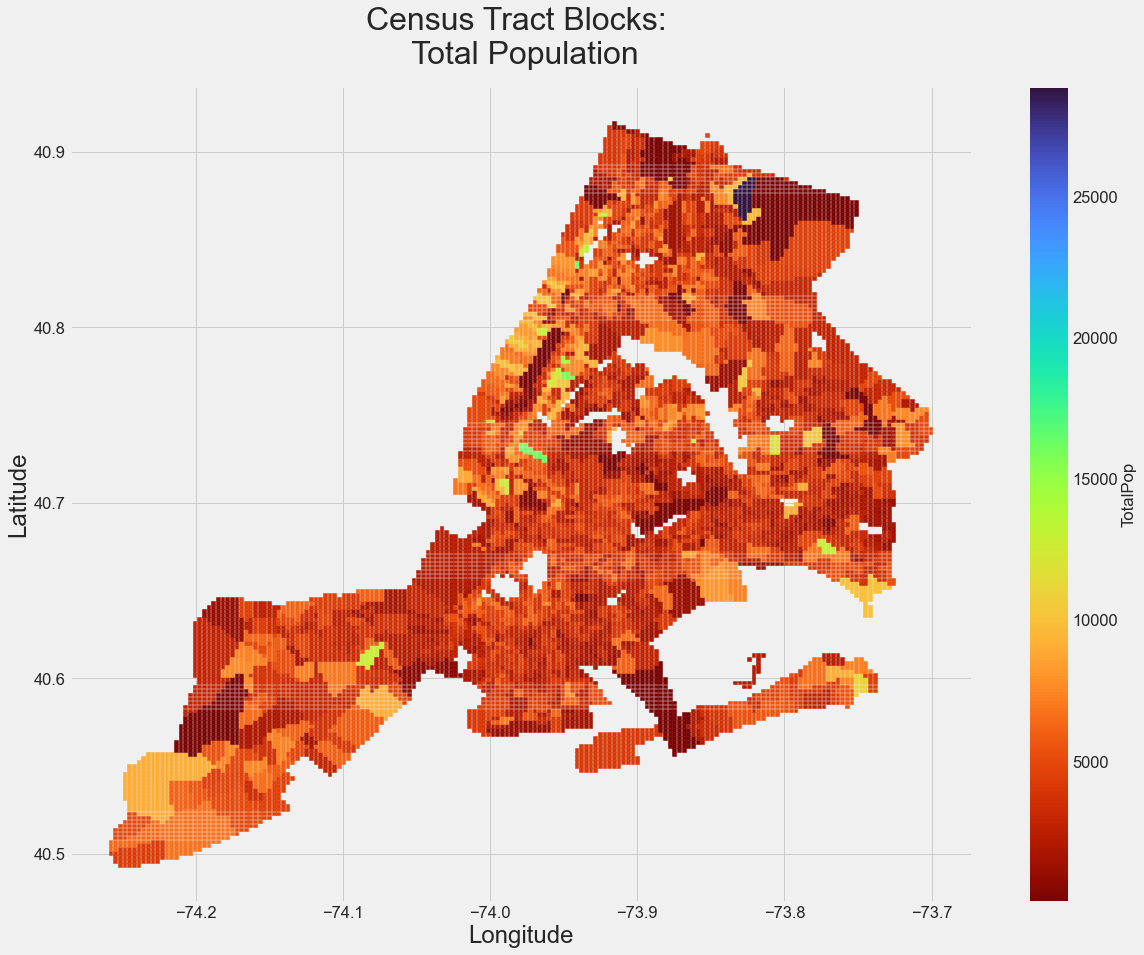

In [9]:
census_blocks.plot(kind='scatter', x='Longitude', y='Latitude', 
                                    c='TotalPop', cmap='turbo_r', 
                                    figsize=(18, 14), marker='s', s=14, alpha=1, legend=True)
plt.ylabel('Latitude', fontsize=24)
plt.xlabel('Longitude', fontsize=24)
plt.title(f'Census Tract Blocks: \n Total Population', fontsize=32, y=1.02);

Below is the same plot, but using the consolidated Census Tract points used for the Haversine calculations at the end of the data cleaning notebook. Here, each set of blocks that makes up a Census Tract has had all the Latitudes and Longitudes in that tract averaged to make a single point representing that Tract, reducing processing requirements by almost 5x 

2113

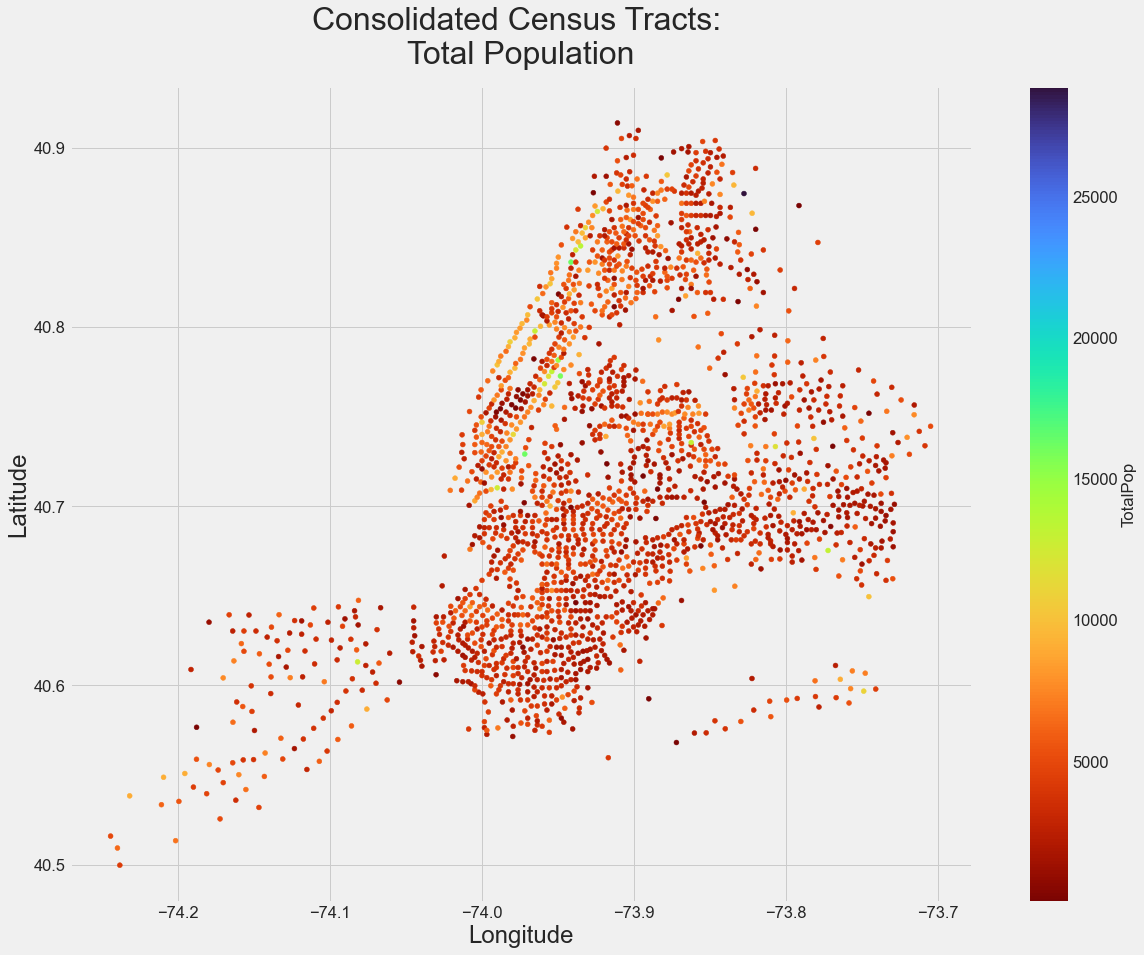

In [10]:
census.plot(kind='scatter', x='Longitude', y='Latitude', 
                                    c='TotalPop', cmap="turbo_r", 
                                    figsize=(18, 14), marker='o', s=24, alpha=1, legend=True)
plt.ylabel('Latitude', fontsize=24)
plt.xlabel('Longitude', fontsize=24)
plt.title('Consolidated Census Tracts: \nTotal Population', fontsize=32, y=1.02);
census.shape[0]

#### Arrests 

In [11]:
# drop arrest key column, internal classification code 
nypd['ARREST_DATE'] = pd.to_datetime(nypd['ARREST_DATE'])

# encode boro
nypd['ARREST_BORO'] = nypd['ARREST_BORO'].map({'K': 0, 'M': 1, 'B': 2, 'Q': 3, 'S': 4})

# encode age range
nypd['perp_age_enc'] = nypd['AGE_GROUP'].map({"<18": 0, "18-24": 1, "25-44": 2, "45-64": 3, "65+": 4})

# encode gender
nypd['perp_gender'] = nypd['PERP_SEX'].map({'M': 0, 'F': 1})

# drop remainig cols
nypd = nypd.drop(columns=['ARREST_KEY', 'PD_CD', 'AGE_GROUP', 'LAW_CAT_CD', 'Lon_Lat'])

In [12]:
nypd.isnull().sum()

ARREST_DATE             0
PD_DESC              9029
KY_CD                9029
OFNS_DESC            9029
LAW_CODE              196
ARREST_BORO             8
ARREST_PRECINCT         0
JURISDICTION_CODE      10
PERP_SEX                0
PERP_RACE               0
X_COORD_CD              1
Y_COORD_CD              1
Latitude                1
Longitude               1
perp_age_enc          195
perp_gender             0
dtype: int64

In [13]:
# dataset is large enough to drop few null rows and weird geographic outliers
# missing PD_DESC data would make those arrest records unusable for our purposes 
nypd = nypd.dropna()
nypd = nypd[nypd['Latitude'] < 41]
nypd.shape

(4996622, 16)

#### Arrests for nonviolent offenses
The methodology for selecting the list of alleged offenses below is in the arrests EDA notebook

In [14]:
# Resisting Arrest was included here as it is a response to an officer, not an instigation 
# of violence 
nonviolent = ['MARIJUANA, SALE',  'MISCHIEF,CRIM', 'PROSTITUTION', 'CONTROLLED SUBSTANCE,\s*POSSE',
              'CONTROLLED SUBSTANCE,\s*INTENT', 'CONTROLLED SUBSTANCE,\s*SALE', 'RESISTING ARREST', 
              'DISORDERLY CONDUCT', 'FORGERY,ETC.-MISD', 'DRUG PARAPHERNALIA', 'MARIJUANA, POSSESSION', 'LOITERING', 'ASSEMBLY,UNLAWFUL', 'BAIL JUMPING', 'BURGLARS TOOLS,UNCLASSIFIED', 
              'POSSESSION HYPODERMIC INSTRUMENT', 'GAMBLING', 'PARKR&R,UNCLASSIFIED VIOLATION', 
              'CRIMINAL MISCHIEF']

nv = {charge: idx for idx, charge in enumerate(nonviolent)}

# This removes child and compulsory prostitution so it does not get iterated & encoded
# While we count prostitution as a nonviolent offense, we believe coerced prostitution
# and child prostitution to be violent crimes 
temp_nypd = nypd[~(nypd.PD_DESC.str.contains('PROSTITUTION') 
     & ((nypd.PD_DESC.str.contains('UNDE') 
       | nypd.PD_DESC.str.contains('COMPULSORY'))))].copy()

numeric = pd.DataFrame()
for i in nonviolent:
    temp_nypd['alleged_offense'] = nv[i]
    numeric = pd.concat([numeric, temp_nypd[temp_nypd.PD_DESC.str.contains(i)]], ignore_index=True)


numeric['PERP_RACE'] = numeric['PERP_RACE'].map({
    'BLACK': 0,
    'BLACK HISPANIC': 1,
    'WHITE HISPANIC': 1,
    'AMERICAN INDIAN/ALASKAN NATIVE': 2,
    'ASIAN / PACIFIC ISLANDER': 3, #2
    'WHITE': 4, #3

})

# drops OTHER and UNKNOWNS from the PERP_RACE column as our subsequent work depends on being 
# able to match PERP_RACE to quantified census demographics 
numeric = numeric.dropna()
numeric = numeric.reset_index(drop=True)

---
## Add Census Tract 
---
## -- WARNING --
This code can take a long time to run, as its calculating euclidian distance for approx. 4.5 billion sets of coordinates. Vectorizing and/or adding parallel processing to this is one of our Next Steps 
## -- WARNING --

In [ ]:
%%time
numeric['CensusTract'] = 0
for i in tqdm(numeric.index):
# for i in tqdm(numeric[:50].index): # shorter run for troubleshooting
    min_dist = 1000
    closest_census_track = 0 
    for j in census.index:
        current = haversine(
                    (numeric.loc[i, 'Latitude'], numeric.loc[i, 'Longitude']),
                    (blocks.loc[j, 'Latitude'], blocks.loc[j, 'Longitude']),
                    unit='mi')
#         print(current)
#         print(min_dist)
#         print()
        if current < min_dist:
            min_dist = current
            closest_census_track = census.loc[j, 'CensusTract']
#                 print(closest_census_track)
    numeric.loc[i, 'CensusTract'] = closest_census_track 
    
numeric.CensusTract.value_counts()

---
## Exports
---

In [ ]:
# recommended to leave this cell commented out unless the Census Tract calculations have 
# been added 
# numeric.to_csv('./cleaned_datasets/final_nonviolent_arrests_tract.csv', index=False)
nypd.to_csv('./cleaned_datasets/cleaned_all_nypd_arrests_data.csv')
census.to_csv('./cleaned_datasets/cleaned_census_data.csv')
census_blocks.to_csv('./cleaned_datasets/cleaned_census_blocks_data.csv')